

# MEG source spase analysis on own data


<div class="alert alert-success" role="alert">

# Preamble: Activate environment
In the previous notebook, we installed a python environment. If you haven't done so, please go back to the ```01_setup_virtual_environment.ipynb``` and complete this before proceeding.

If you closed/stopped the UCloud run between then and now, we will need to reactivate the environment.

For this we use a bash script with a subset of the lines we used for setting up the environment

The script is called ```activate.sh``` This should be located in your working directory. If not, save the following in a file with this filename.

```bash
. /work/<MY DIRECTORY NUMBER>/virt_env/bin/activate
python -m ipykernel install --user --name=virt_env
echo Done! Remember changing the kernel in Jupyter.
```

<br>

If you haven't done so already, open the ```activate.sh``` script and change the path to your own folder in 'student_folders'.

For example: /work/student_folders/idas_folder/notebooks/virt_env/bin/activate

</div>

In [1]:
import os

path='/work/student_folders/Ida_D_folder/notebooks_fMRI/' # Remember to change this to your own path
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


In [25]:
# IMPORTS OF PACKAGES

from os.path import join
import matplotlib.pyplot as plt
import mne
import numpy as np
import glob
import pandas as pd


plt.ion()  # toggle interactive plotting

In [26]:
# PATH
raw_name =  '/work/student_folders/Ida_D_folder/notebooks_MEG/Portfolio_3/sessA+B.fif'

# Get the MEG data first

In [27]:
# READ RAW DATA
fname= raw_name
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file /work/student_folders/Ida_D_folder/notebooks_MEG/Portfolio_3/sessA+B.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 259000 ... 1704999 =    259.000 ...  1704.999 secs
Ready.
Reading 0 ... 1445999  =      0.000 ...  1445.999 secs...


/tmp/ipykernel_791/3326702882.py:3: RuntimeWarning: This filename (/work/student_folders/Ida_D_folder/notebooks_MEG/Portfolio_3/sessA+B.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


In [28]:
# FILTER RAW
# Apply a low-pass filter at 40 Hz (i.e., everything below 40 Hz passes through the filter)
raw.filter(l_freq=None, h_freq=40, n_jobs=4)  # alters raw in-place

Filtering raw data in 5 contiguous segments
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 252 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 306 out of 306 | elapsed:    8.9s finished


<Raw | sessA+B.fif, 323 x 1446000 (1446.0 s), ~3.48 GB, data loaded>

# MEG epochs 

In [29]:
# %% FIND EVENTS

events = mne.find_events(raw, min_duration=0.002, consecutive=True)  ## returns a numpy array

# due to the online filtering of the MEG data, the square waves that constitute the trigger values 
# in the STI101-channel are sometimes not read very well during this process - and therefore we'll 
# only focus on those triggers that correspond to trigger values that we know are relevant
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

# unfortunately, the STI101-channel is really acting up in this dataset, and therefore multiple of the 
# relevant triggers are sometimes read as repeated values within a few milliseconds... gotta fix that too
# We identify for which rows the difference between two consecutive trigger values is 0 (i.e. they're identical 
# - cuz that shouldn't ever happen (check the event_id to (maybe) make sense of this)
repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

3530 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15 110 120 126 130 134 140 156 210 211
 220 221 230 231 238 239 240 241 243 246 247 252 254 255]


/tmp/ipykernel_791/1714037254.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(cropped_events, sfreq=raw.info["sfreq"]);


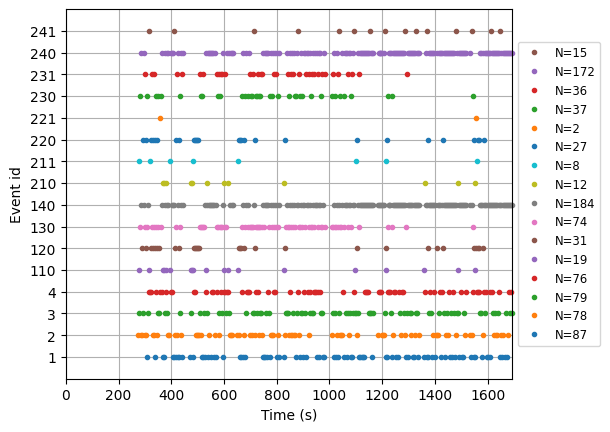

In [31]:
#Plot
mne.viz.plot_events(cropped_events, sfreq=raw.info["sfreq"]);


## Cheking numbers for events

In [30]:
# Do we have the correct number of deck-screens, deck-selection and win-/loss-screens?

## Checking how many events there are for being presented the decks
#print(len(cropped_events[cropped_events[:,2]<10,2]))
print("Number of events for viewing the decks:", len(cropped_events[cropped_events[:, 2] < 10, 2]))

## Checking how many events there are for selecting deck A, B, C or D
print("Number of events for selecting deck A, B, C or D:", len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]))

## Checking how many events there are for switching between deck A, B, C or D
print("Number of events for switching between deck A, B, C or D:", len(cropped_events[(cropped_events[:,2]>10) & (cropped_events[:,2]<15), 2]))

## Checking how many events there are for win and loss screens
print("Number of events for win and loss screens", len(cropped_events[(cropped_events[:,2]>200) & (cropped_events[:,2]<250), 2]))

## Checking how many events there are for win screens
print("Number of events for win:", len(cropped_events[np.isin(cropped_events[:, 2], [210, 220, 230, 240]), 2]))

## Checking how many events there are for loss screens
print("Number of events for loss:", len(cropped_events[np.isin(cropped_events[:, 2], [211, 221, 231, 241]), 2]))

Number of events for viewing the decks: 320
Number of events for selecting deck A, B, C or D: 308
Number of events for switching between deck A, B, C or D: 0
Number of events for win and loss screens 309
Number of events for win: 248
Number of events for loss: 61


In [32]:
# Load logfiles and check numbers in there

# loading in the logfiles
# Define variables
log_path = '/work/MEG_data/logfiles'
sess_prefix = '143'  # Prefix for matching

# Use glob to match all files starting with the prefix
log_files = glob.glob(join(log_path, f"{sess_prefix}*"))


df_load = []
for lf in np.sort(log_files):
    print(lf)
    df_load.append(pd.read_csv(join(log_path, lf)))
                        
df = pd.concat(df_load)


# Select only the relevant columns
df_cropped = df.loc[:, ['win', 'loss', 'deck_select']]

# Add a column for the net sum per trial
df_cropped['net_sum'] = df_cropped['win'] - df_cropped['loss'].abs()

# Add a column with the true trigger
df_cropped['true_trigger'] = df_cropped.apply(
    lambda row: 
    210 if row['net_sum'] >= 0 and row['deck_select'] == 1 else
    220 if row['net_sum'] >= 0 and row['deck_select'] == 2 else
    230 if row['net_sum'] >= 0 and row['deck_select'] == 3 else
    240 if row['net_sum'] >= 0 and row['deck_select'] == 4 else
    211 if row['net_sum'] < 0 and row['deck_select'] == 1 else
    221 if row['net_sum'] < 0 and row['deck_select'] == 2 else
    231 if row['net_sum'] < 0 and row['deck_select'] == 3 else
    241 if row['net_sum'] < 0 and row['deck_select'] == 4 else
    None, # default fallback, should not occur with proper input
    axis=1
)

# print the entire df
with pd.option_context('display.max_rows', None):
    print(df_cropped)


loss_trials = (df_cropped['net_sum'] < 0).sum()
win_trials = (df_cropped['net_sum'] >= 0).sum()

print("Number of loss trials:", loss_trials)
print("Number of win trials:", win_trials)


/work/MEG_data/logfiles/143A_sess_1 (2024-09-24 10-57-42).csv
/work/MEG_data/logfiles/143A_sess_2 (2024-09-24 11-03-07).csv
/work/MEG_data/logfiles/143A_sess_3 (2024-09-24 11-07-11).csv
/work/MEG_data/logfiles/143A_sess_4 (2024-09-24 11-11-54).csv
/work/MEG_data/logfiles/143B_sess_1 (2024-09-24 11-17-41).csv
/work/MEG_data/logfiles/143B_sess_2 (2024-09-24 11-20-36).csv
/work/MEG_data/logfiles/143B_sess_3 (2024-09-24 11-23-31).csv
/work/MEG_data/logfiles/143B_sess_4 (2024-09-24 11-26-25).csv
    win  loss  deck_select  net_sum  true_trigger
0   100  -250            1     -150           211
1    50     0            3       50           230
2    50     0            4       50           240
3   100     0            2      100           220
4    50     0            4       50           240
5    50   -50            3        0           230
6   100     0            2      100           220
7    50     0            3       50           230
8    50  -250            4     -200           241
9   

In [33]:
#This is the structure of interesting triggers / events
event_id = {'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            'Visual/Deck/Two': 2, # Deck 2 marked
            'Visual/Deck/Three': 3, # Deck 3 marked
            'Visual/Deck/Four': 4, # Deck 4 marked
            'Visual/Win/One': 210, # Win screen, deck 1
            'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            'Visual/Win/Four': 240, # Win screen, deck 4
            'Visual/Loss/One': 211, # Loss screen, deck 1
            'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            'Visual/Loss/Four': 241, # Loss screen, deck 4
            'Response/Switch/First': 11, # y button press (switch), first
            'Response/Switch/Second': 12, # y button press, second
            'Response/Switch/Third': 13, # y button press, third
            'Response/Switch/Fourth': 14, # y button press, fourth
            'Response/Select/One': 110, # b button press (select), deck 1
            'Response/Select/Two': 120, # b button press, deck 2
            'Response/Select/Three': 130, # b button press, deck 3
            'Response/Select/Four': 140, # b button press, deck 4
              }   


In [34]:
#Segment the data into epochs
#Epochs can be rejected, if the signal exceeds the range that is expected. Read more here: https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs
# reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V   #You can try it out
reject = None    #Otherwise, all epochs are kept
#Create the epochs around the events. tmin is the time before the event, and tmax the time after the event.
epochs = mne.Epochs(
    raw,
    cropped_events,
    event_id,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    preload=True,
    proj=False,
)  ## have proj True, if you wanna reject


Not setting metadata
937 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 937 events and 1201 original time points ...


/tmp/ipykernel_791/2270580226.py:6: RuntimeWarning: No matching events found for Response/Switch/First (event id 11)
  epochs = mne.Epochs(
/tmp/ipykernel_791/2270580226.py:6: RuntimeWarning: No matching events found for Response/Switch/Second (event id 12)
  epochs = mne.Epochs(
/tmp/ipykernel_791/2270580226.py:6: RuntimeWarning: No matching events found for Response/Switch/Third (event id 13)
  epochs = mne.Epochs(
/tmp/ipykernel_791/2270580226.py:6: RuntimeWarning: No matching events found for Response/Switch/Fourth (event id 14)
  epochs = mne.Epochs(


0 bad epochs dropped


In [35]:
#Pick only MEG channels
epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False, stim=False, syst=False)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Epochs | 937 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~2.57 GB, data loaded,
 'Visual/Deck/One': 87
 'Visual/Deck/Two': 78
 'Visual/Deck/Three': 79
 'Visual/Deck/Four': 76
 'Visual/Win/One': 12
 'Visual/Win/Two': 27
 'Visual/Win/Three': 37
 'Visual/Win/Four': 172
 'Visual/Loss/One': 8
 'Visual/Loss/Two': 2
 and 10 more events ...>

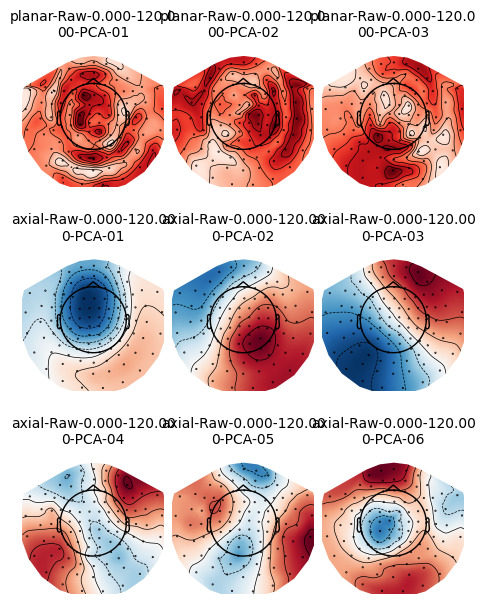

Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...


<Epochs | 937 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~2.57 GB, data loaded,
 'Visual/Deck/One': 87
 'Visual/Deck/Two': 78
 'Visual/Deck/Three': 79
 'Visual/Deck/Four': 76
 'Visual/Win/One': 12
 'Visual/Win/Two': 27
 'Visual/Win/Three': 37
 'Visual/Win/Four': 172
 'Visual/Loss/One': 8
 'Visual/Loss/Two': 2
 and 10 more events ...>

In [36]:
# SSP PROJECTIONS
#SSP projectors are calculated to remove environmental noise from the MEG signal. Read more here: https://mne.tools/stable/auto_tutorials/preprocessing/45_projectors_background.html#tut-projectors-background
#Visualize the projectors that contain signal from outside the head
#mne.viz.plot_projs_topomap(evoked.info["projs"], evoked.info)
mne.viz.plot_projs_topomap(epochs.info["projs"], epochs.info)

#apply the projections
epochs.apply_proj()

In [37]:
event_id

#need the 4 loss


{'Visual/Deck/One': 1,
 'Visual/Deck/Two': 2,
 'Visual/Deck/Three': 3,
 'Visual/Deck/Four': 4,
 'Visual/Win/One': 210,
 'Visual/Win/Two': 220,
 'Visual/Win/Three': 230,
 'Visual/Win/Four': 240,
 'Visual/Loss/One': 211,
 'Visual/Loss/Two': 221,
 'Visual/Loss/Three': 231,
 'Visual/Loss/Four': 241,
 'Response/Switch/First': 11,
 'Response/Switch/Second': 12,
 'Response/Switch/Third': 13,
 'Response/Switch/Fourth': 14,
 'Response/Select/One': 110,
 'Response/Select/Two': 120,
 'Response/Select/Three': 130,
 'Response/Select/Four': 140}

In [39]:
# EVOKED - AVERAGE - projections are now applied

#new list to only have what we need
evokeds_2 = list()
#trim event_id to our need
# List of keys to keep
keys_to_keep = ['Visual/Loss/One','Visual/Loss/Two','Visual/Loss/Three','Visual/Loss/Four']
# Filter the dictionary
new_event_id = {key: event_id[key] for key in keys_to_keep}
print(new_event_id)

#make new evoke
for event in new_event_id:

    evoked_new = epochs[event].average()
    evokeds_2.append(evoked_new)
    #evoked.plot(window_title=evoked.comment)


# from here on evoked is replaced with evoked_new


{'Visual/Loss/One': 211, 'Visual/Loss/Two': 221, 'Visual/Loss/Three': 231, 'Visual/Loss/Four': 241}


# Source reconstruction - going to source space

In [40]:
# SOURCE RECONSTRUCTION 

bem_path = "/work/freesurfer/" + "0143/bem"    
subjects_dir = "/work/freesurfer/"    #path to all subjects
fwd_name = "0143-sessA-src-fwd.fif"  
subject = '0143'

# read forward solution
fwd = mne.read_forward_solution(join(bem_path, fwd_name))
src = fwd["src"]  # where are the sources
trans = fwd["mri_head_t"]  # what's the transformation between mri and head space
info = epochs.info  # where are the sensors?
bem_sol = fwd["sol"]  # how do electric fields spread from the sources inside the head?


Reading forward solution from /work/freesurfer/0143/bem/0143-sessA-src-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


/tmp/ipykernel_791/2875878331.py:3: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  noise_cov = mne.compute_covariance(epochs, tmax=0.000)
/tmp/ipykernel_791/2875878331.py:3: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  noise_cov = mne.compute_covariance(epochs, tmax=0.000)
/tmp/ipykernel_791/2875878331.py:3: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  noise_cov = mne.compute_covariance(epochs, tmax=0.000)
/tmp/ipykernel_791/2875878331.py:3: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log

    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 188337
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 102 dim * 4.8e+08  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 204 dim * 7e+09  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


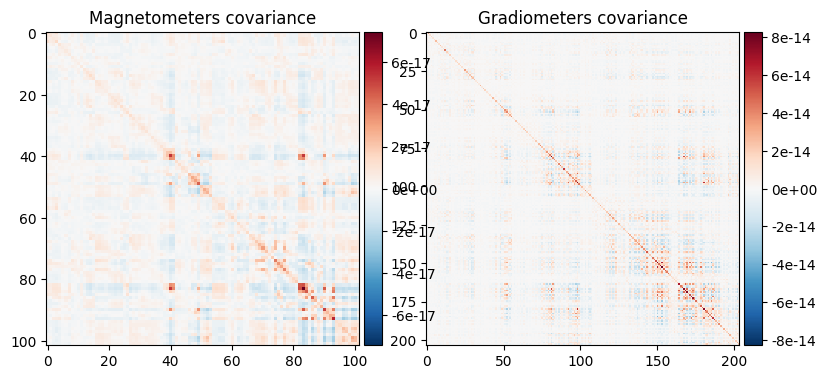

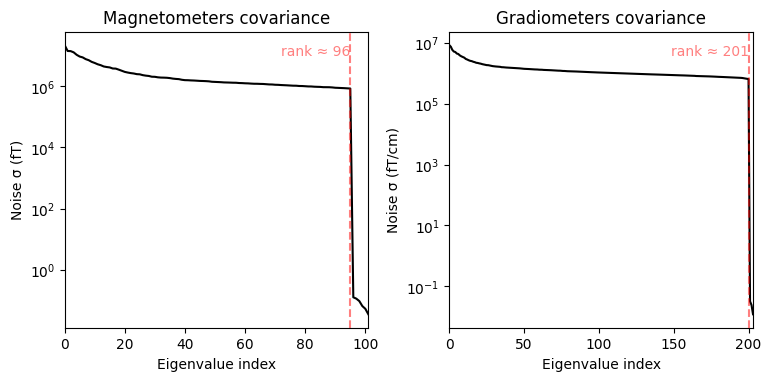

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [41]:
# estimate covariance in the baseline to whiten magnetometers and gradiometers, 
# i.e. normalizing magnetometers, gradiometers and electrode readings to make them comparable
noise_cov = mne.compute_covariance(epochs, tmax=0.000)
noise_cov.plot(epochs.info)  # not full range due to projectors projected out

In [42]:
# %% operator that specifies how noise cov should be applied to the fwd
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7725/8196 = 10.007797
    scale = 4.84277e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 0.0005 (2.2e-16 eps * 306 dim * 7.3e+09  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened a

In [43]:
# estimate source time courses for evoked_new responses

stc = mne.minimum_norm.apply_inverse(evoked_new, inverse_operator, method="MNE")
print(stc.data.shape)
print(src)
# stc.plot(subjects_dir=subjects_dir, hemi='both', initial_time=0.170)



Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 15
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
Applying inverse operator to "Visual/Loss/Four"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  43.5% variance
    Combining the current components...
[done]
(8196, 1201)
<SourceSpaces: [<surface (lh), n_vertices=119272, n_used=4098>, <surface (rh), n_vertices=120849, n_used=4098>] head coords, subject '0143', ~24.2 MB>


## Redoing some operations to make a plot
In order to get some plots with dSPM, we need to use volume calculations instead of surfaces calculations.

Hence, here we redo the forward model and inverse operations to get a volume file.

In [44]:
#Access labels to choose from (corresponds to brain areas)

import nibabel as nib

# Path to aseg.mgz file
aseg_path = "/work/freesurfer/0143/mri/aseg.mgz"

# Load the aseg file
aseg = nib.load(aseg_path)

# Get the data array
aseg_data = aseg.get_fdata()

# Get the unique labels in the aseg file
unique_labels = np.unique(aseg_data)
print("Unique labels in aseg.mgz:", unique_labels)

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:49, 1.40kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<03:12, 2.65kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<03:00, 2.69kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<03:46, 4.07kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<06:03, 16.9kB/s]


Unique labels in aseg.mgz: [  0.   2.   3.   4.   5.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  24.  26.  28.  30.  31.  41.  42.  43.  44.  46.  47.  49.
  50.  51.  52.  53.  54.  58.  60.  62.  63.  77.  85. 251. 252. 253.
 254. 255.]


In [45]:
# Get the names for the labels

# Path to FreeSurfer LUT file (i downloaded from online and uploaded this)
lut_path = "/work/student_folders/Ida_D_folder/notebooks_MEG/Portfolio_3/FreeSurferColorLUT.txt"

# Load the LUT into a dictionary
def load_lut(file_path):
    lut = {}
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip() and not line.startswith('#'):  # Skip comments and empty lines
                parts = line.split()
                label_id = int(parts[0])  # Numeric ID
                label_name = " ".join(parts[1:-4])  # Name of the label
                lut[label_id] = label_name
    return lut

# Load LUT
lut = load_lut(lut_path)

# Unique labels from aseg.mgz
unique_labels = [0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 85, 251, 252, 253, 254, 255]

# Map and print labels with their names
for label in unique_labels:
    label_name = lut.get(label, "Unknown")
    print(f"{label}: {label_name}")


0: Unknown
2: Left-Cerebral-White-Matter
3: Left-Cerebral-Cortex
4: Left-Lateral-Ventricle
5: Left-Inf-Lat-Vent
7: Left-Cerebellum-White-Matter
8: Left-Cerebellum-Cortex
10: Left-Thalamus-Proper
11: Left-Caudate
12: Left-Putamen
13: Left-Pallidum
14: 3rd-Ventricle
15: 4th-Ventricle
16: Brain-Stem
17: Left-Hippocampus
18: Left-Amygdala
24: CSF
26: Left-Accumbens-area
28: Left-VentralDC
30: Left-vessel
31: Left-choroid-plexus
41: Right-Cerebral-White-Matter
42: Right-Cerebral-Cortex
43: Right-Lateral-Ventricle
44: Right-Inf-Lat-Vent
46: Right-Cerebellum-White-Matter
47: Right-Cerebellum-Cortex
49: Right-Thalamus-Proper
50: Right-Caudate
51: Right-Putamen
52: Right-Pallidum
53: Right-Hippocampus
54: Right-Amygdala
58: Right-Accumbens-area
60: Right-VentralDC
62: Right-vessel
63: Right-choroid-plexus
77: WM-hypointensities
85: Optic-Chiasm
251: CC_Posterior
252: CC_Mid_Posterior
253: CC_Central
254: CC_Mid_Anterior
255: CC_Anterior


In [46]:
# Define labels, can only be from the list
labels_vol = ["Left-Amygdala", "Right-Amygdala"]

mri_path = "/work/freesurfer/" + "0143/mri"
fname_aseg = mri_path + "/aseg.mgz"


vol_src = mne.setup_volume_source_space(
    subject=subject,
    mri=fname_aseg,
    pos=10.0,
    bem=bem_path + '/0143-bem-sol.fif',
    volume_label=labels_vol,
    subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=True,
)

# Generate the mixed source space
src += vol_src
print(
    f"The source space contains {len(src)} spaces and "
    f"{sum(s['nuse'] for s in src)} vertices"
)

BEM              : /work/freesurfer/0143/bem/0143-bem-sol.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : /work/freesurfer/0143/mri/aseg.mgz

Reading /work/freesurfer/0143/mri/aseg.mgz...

Loaded inner skull from /work/freesurfer/0143/bem/0143-bem-sol.fif (2562 nodes)
Surface CM = (   1.2  -18.3   33.4) mm
Surface fits inside a sphere with radius   95.4 mm
Surface extent:
    x =  -66.0 ...   70.4 mm
    y = -101.5 ...   76.6 mm
    z =  -44.1 ...  102.8 mm
Grid extent:
    x =  -70.0 ...   80.0 mm
    y = -110.0 ...   80.0 mm
    z =  -50.0 ...  110.0 mm
5440 sources before omitting any.
3440 sources after omitting infeasible sources not within 0.0 - 95.4 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 3440 points...
    Found  456/3440 points inside  an interior sphere of radius   47.8 mm
    Found    0/3440 points

In [47]:
## forward model as a volume

path_trans = join(bem_path, '0143-trans.fif')
output_name = bem_path + '\0143-sessA-src-fwd_vol.fif'

info = mne.io.read_info(fname)
trans = path_trans   
bem = join(bem_path, '0143-bem-sol.fif')            

fwd_vol = mne.make_forward_solution(info, trans, vol_src, bem)

    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
Source space          : <SourceSpaces: [<volume (Left-Amygdala), n_used=1>, <volume (Right-Amygdala), n_used=1>] MRI (surface RAS) coords, subject '0143', ~2.4 MB>
MRI -> head transform : /work/freesurfer/0143/bem/0143-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0143/bem/0143-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 2 activ

In [48]:
#inverse model
inverse_operator_vol = mne.minimum_norm.make_inverse_operator(info, fwd_vol, noise_cov)

Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 3/2 = 1.171073
    scale = 8.34711e-08 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 0.0005 (2.2e-16 eps * 306 dim * 7.3e+09  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 10.6958
    scaling factor to adjust the trace = 2.95236e+06 (nchan = 306 nzero = 9)


In [49]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

#inverse_operator = read_inverse_operator(fname_inv)
src_vol = inverse_operator_vol['src']

# Compute inverse solution
stc_vol = mne.minimum_norm.apply_inverse(evoked_new, inverse_operator_vol, lambda2, method)
#stc.crop(0.0, 0.2)


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 15
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "Visual/Loss/Four"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained   5.2% variance
    Combining the current components...
    dSPM...
[done]


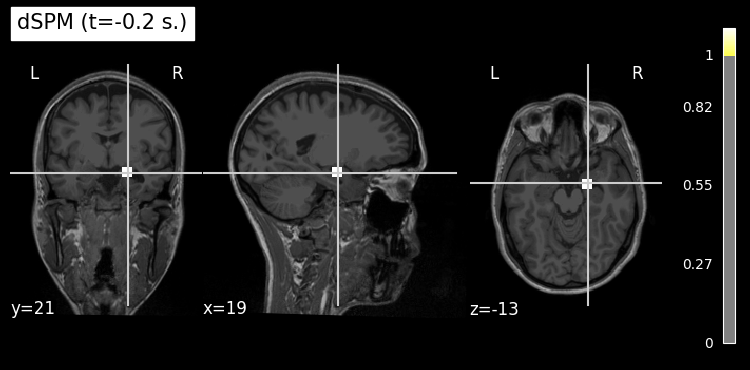

In [50]:
#Finally, we can make a plot on ucloud!

# Export result as a 4D nifti object
img = stc_vol.as_volume(src_vol, mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = join(mri_path, 'T1.mgz')

plot_stat_map(index_img(img, 50), str(t1_fname), threshold=1.,
              title='%s (t=%.1f s.)' % (method, stc_vol.times[50]))

plt.show()